# **RAG (Retrieval Augmented Generation).**

В проекте создадим туристический RAG, проведем EDA.

Нам дан набор данных, содержащий информацию о памятниках, архитектуре и других значимых местах. В данных есть:
* название достопримечательности;
* идентификатор на WikiData;
* город расположения;
* координаты долготы и широты;
* описание (извлеченное из WikiData);
* изображение в формате base64;
* сгенерированное описание изображения (генерация с помощью модели BLIP).

Некоторые из памятников могут встречаться несколько раз, но с различными изображениями, из которых не все могут быть качественными. Для компенсации этого даны текстовые описания.

Часть данных взята с Национальной технологической олимпиады студентов по CV. Базовое решение предполагает использование мультимодального ru-CLIP. Но в данном проекте мы решим эту задачу творчески, используя NLP подход.

In [11]:
import base64
import gdown
import hashlib
import llama_cpp
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import PIL
import re
import requests
import seaborn as sns
import shutil
import torch
import umap.umap_ as umap
import warnings

from collections import Counter
from FlagEmbedding import FlagReranker
from googletrans import Translator
from huggingface_hub import hf_hub_download
from io import BytesIO
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_core.documents import Document
from llama_cpp import Llama
from nltk.corpus import stopwords
from PIL import Image
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tqdm.notebook import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer
from typing import Optional, List, Tuple, Any

In [23]:
def has_no_russian(text):
    """Проверяет, содержит ли текст хотя бы одну русскую букву"""
    if pd.isna(text) or not str(text).strip():
        return False  # Не обрабатываем NaN и пустые строки
    return not bool(russian_pattern.search(str(text)))

In [24]:
def preprocess(text):
    # Очистка текста
    text = re.sub(r'\W', ' ', text.lower())  # Всё, что не буквы, цифры и подчёркивание - заменяем на пробелы
    return text

In [25]:
def print_cluster_samples(df_cleaned, n_samples=5, max_chars=1000):
    # Функция для вывода примеров
    cluster_counts = df_cleaned['cluster'].value_counts().sort_index()

    print(f"\n{'='*9}")
    print(f"АНАЛИЗ 9 КЛАСТЕРОВ (всего документов: {len(df_cleaned)})")
    print(f"{'='*50}\n")

    for cluster_id in sorted(df_cleaned['cluster'].unique()):
        cluster_size = cluster_counts[cluster_id]

        print(f"КЛАСТЕР #{cluster_id} (документов: {cluster_size})")
        print(f"{'-'*30}")

        samples = df_cleaned[df_cleaned['cluster'] == cluster_id].sample(
            n=min(n_samples, cluster_size),
            random_state=42
        )

        for i, (idx, row) in enumerate(samples.iterrows(), 1):
            text = row['combined_text'].replace('\n', ' ').strip()
            print(text[:max_chars] + ("..." if len(text) > max_chars else ""))

        print(f"\n{'='*30}")

In [26]:
def get_image(data):
    # Функция для вывода изображений
    image = Image.open(BytesIO(base64.b64decode(data))).convert('RGB')
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [27]:
def process_text(text):
    messages = [
        {"role": "system", "content": "Ты бот копирайтер, твоя задача - просто переписать красиво и лаконично текст, убрав повторы и ничего не добавляя от себя"},
        {"role": "user", "content": text},
    ]
    return RAG.chat(messages)

In [28]:
def data_preprocess(df):
    # Фильтрация: text_type == 'main' И длина text > 100
    df_main = df[(df['text_type'] == 'main') & (df['text'].str.len() > 50)]
    
    # Проверка, что данных достаточно для выборки
    if len(df_main) < 100:
        raise ValueError(f"Недостаточно данных: только {len(df_main)} строк подходят.")
    
    # Стратифицированная выборка (пропорционально городам)
    df_stratified, _ = train_test_split(
        df_main,
        train_size=100,
        stratify=df_main['City'],  # Важно: стратификация по df_main, а не df!
        random_state=42
    )

    result_list = []
    # Добавляем tqdm для отображения прогресса
    for i in tqdm(range(df_stratified.shape[0]), desc="Обработка данных", unit="row"):
        row = df_stratified.iloc[i]

        messages = [
            {"role": "system", "content": "Задай один вопрос по тексту ниже таким образом, что бы текст ниже служил полным ответом на него, постарайся как модно меньше слов использовать из текста "},
            {"role": "user", "content": row['text']},
        ]
        question = RAG.chat(messages)
        
        ground_truths = row['text']
        
        answer, _ = RAG.get_answer(question)

        messages = [
            {"role": "system", "content": "Извлеки из ответа именованные сущности, приведи их к нормальной форме и размести их через точку с запятой"},
            {"role": "user", "content": row['text']},
        ]
        contexts = RAG.chat(messages)

        new_row = [question, ground_truths, answer, contexts]
        result_list.append(new_row)

    df = pd.DataFrame(result_list, columns=['question', 'ground_truths', 'answer', 'contexts'])

    return df

In [29]:
def answer_relevancy(model, df):
    '''
    Метрика Answer Relevancy для проверки RAGAS
    '''
    count = df.shape[0]
    if count == 0:
        return 0.0  # или можно вызвать исключение
    
    scores = 0.0
    for i in range(count):
        row = df.iloc[i]
    
        q_emb = model.get_embeddings(row['question'])
        a_emb = model.get_embeddings(row['answer'])

        score = cosine_similarity(q_emb, a_emb)  # преобразуем в 2D массивы
        scores += score[0][0]

    return scores / count

In [30]:
def answer_semantic_similarity(model, df):
    '''
    Метрика Answer Semantic Similarity для проверки RAGAS
    '''
    count = df.shape[0]
    if count == 0:
        return 0.0  # или можно вызвать исключение
    
    scores = 0.0
    for i in range(count):
        row = df.iloc[i]
    
        q_emb = model.get_embeddings(row['ground_truths'])
        a_emb = model.get_embeddings(row['answer'])

        score = cosine_similarity(q_emb, a_emb)  # преобразуем в 2D массивы
        scores += score[0][0]

    return scores / count

In [31]:
class RagModel:
    '''
     Сам RAG на основе выбранных базовых блоков
    '''
    
    def __init__(self) -> None:
        self.db = None
        self.max_images = 4  # Максимум выводимых  изображений

        # LLM t-pro-it-1.0-q4_k_s
        model_path = "t-pro-it-1.0-q4_k_s.gguf"
        self.llm = Llama(
            model_path = model_path,
            n_gpu_layers = -1,       # Все слои на GPU
            main_gpu = 0,            # Использовать первую видеокарту
            n_threads = 4,           # Потоки CPU для постобработки
            n_ctx = 2048,            # Размер контекста модели, токенов Более чем достаточно для нашеоо случая
            offload_kqv = True,      # Оптимизация памяти
            tensor_split = [0.9],    # 90% VRAM для модели
            verbose = False          # Без вывода логов
        )

        # Модель для создания эмбеддингов
        self.embedder = HuggingFaceEmbeddings(
            model_name="BAAI/bge-m3",
            model_kwargs={"device": "cuda"},  # или "cuda", если есть GPU
            encode_kwargs={"normalize_embeddings": True}
        )

        # Модель реранкера
        self.reranker = FlagReranker('BAAI/bge-reranker-v2-m3', use_fp16=False)

    def get_embeddings(self, texts_list: List[str]) -> List[List[float]]:
        return self.embedder.embed_documents(texts_list)

    def create_documents(self, df: pd.DataFrame) -> list[Document]:
        # Создаем документы LangChain с метаданными
        docs = []
        for _, row in df.iterrows():
            doc = Document(
                page_content=row["text"],  # Основное текстовое содержимое
                metadata={
                    "combined_text": row["combined_text"],
                    "text": row["text"],
                    "image": row["image"],
                    "Lon": row["Lon"],
                    "Lat": row["Lat"],
                    "text_type": row["text_type"],
                },
            )
            docs.append(doc)
        
        # Создаем и сохраняем индекс
        self.db = FAISS.from_documents(docs, self.embedder)
        self.db.save_local("faiss_index")


    def generate_text(self, prompt: str) -> str:
        response = self.llm(
            f"<s>[INST] {prompt} [/INST]",
            max_tokens=500,
            temperature=0.2,
            top_p=0.9,
            echo=False  # Отключаем возврат промпта в ответе
        )

        raw_text = response["choices"][0]["text"].strip()
        clean_text = re.sub(r'\[.*?\]', '', raw_text)
        clean_text = ' '.join(clean_text.split()).strip() 
        return clean_text


    # Режим работы - чат
    def chat(self, messages=False):
        '''
        Пример JSON
        messages = [
            {"role": "system", "content": "Системный промт. Роль и инструкции для модели"},
            {"role": "user", "content": "Текущий вопрос пользователя"},
            {"role": "assistant", "content": "Текст пердыдущего ответа LLM"},
            {"role": "user", "content": "Текст предыдущего ворроса пользователя"}
        ]
        '''
        output = self.llm.create_chat_completion(
            messages = messages,
        )
        return output['choices'][0]['message']['content']


    # Поиск похожих документов с выдачей близости веторов
    def similarity_search(self, query: str) -> List[Any]:
        # Получаем похожие документы с оценками
        results = self.db.similarity_search_with_score(query, k=20)
        
        # Словарь для хранения уникальных документов (ключ - содержание документа)
        unique_docs = {}
        
        for doc, score in results:
            # Используем текст документа как ключ для проверки уникальности
            doc_content = doc.page_content
            if doc_content not in unique_docs:
                unique_docs[doc_content] = (doc, score)
            else:
                # Если документ уже есть, можно оставить тот, у которого выше score
                existing_score = unique_docs[doc_content][1]
                if score > existing_score:
                    unique_docs[doc_content] = (doc, score)
        
        # Возвращаем только уникальные документы
        return list(unique_docs.values())


    # Реранкер
    def rerank_documents(self, query: str, documents: List[Tuple[Document, float]], top_k: int = 10) -> List[Tuple[Document, float]]:
        """
        Args:
            query: поисковый запрос
            documents: список кортежей (Document, score) из similarity_search
            top_k: количество возвращаемых документов
            
        Returns:
            Отсортированный список документов с новыми scores
        """
        # Извлекаем тексты документов
        doc_texts = [doc.page_content for doc, _ in documents]
        
        # Создаём пары запрос-документ для реранкера
        pairs = [(query, doc_text) for doc_text in doc_texts]
        
        # Получаем новые scores от реранкера
        rerank_scores = self.reranker.compute_score(pairs)
        
        # Обновляем scores у документов
        reranked_docs = []
        for i, (doc, _) in enumerate(documents):
            reranked_docs.append((doc, float(rerank_scores[i])))
        
        # Сортируем по убыванию score и возвращаем top_k
        reranked_docs.sort(key=lambda x: x[1], reverse=True)
        return reranked_docs[:top_k]


    def display_images(self, documents: List[Document]) -> Optional[List[str]]:
        """
        Отображает изображения из документов с подписями
        Args:
            documents: список документов LangChain с метаданными, содержащими изображения
            
        Returns:
            Список base64 строк изображений или None, если изображений нет
        """
        
        if not documents:
            print("Нет документов для отображения")
            return None
    
        displayed_count = 0
        seen_hashes = set()  # Для хранения хешей изображений
        image_strings = []
        
        fig, axs = plt.subplots(2, 2, figsize=(12, 8))
        axs = axs.ravel()
    
        for doc in documents:
            if displayed_count >= self.max_images:
                break
    
            metadata = doc.metadata
            
            try:
                image_data = base64.b64decode(metadata['image'])
                # Вычисляем хеш изображения
                image_hash = hashlib.sha256(image_data).hexdigest()
                
                if image_hash in seen_hashes:
                    continue
                    
                img = Image.open(BytesIO(image_data)).convert('RGB')
                axs[displayed_count].imshow(img)
                caption = metadata['combined_text'][:50] + '...' if len(metadata['combined_text']) > 50 else metadata['combined_text']
                axs[displayed_count].set_xlabel(caption, fontsize=10, labelpad=10)
                
                seen_hashes.add(image_hash)
                image_strings.append(metadata['image'])
                displayed_count += 1
    
            except Exception as e:
                print(f"Ошибка при обработке изображения: {e}")
                continue
    
        if displayed_count == 0:
            plt.close(fig)
            return None
    
        plt.tight_layout()
        plt.show()
        return image_strings


    def get_answer(self, query: str, display=False) -> Tuple[str, List[Document]]:
        """
        Получает ответ модели на основе поиска и реранкинга документов.
        Args:
            query: поисковый запрос пользователя
            
        Returns:
            Кортеж из:
            - ответ модели (str)
            - список релевантных документов (List[Document])
        """
        # 1. Поиск и реранкинг документов
        docs_with_scores = self.similarity_search(query)
        if not docs_with_scores:
            return "Не найдено подходящих документов", []
            
        reranked_docs = self.rerank_documents(query, docs_with_scores)
        
        # 2. Формирование контекста
        chunks = []
        for doc, score in reranked_docs:
            # Логирование информации о документе
            # print(f"\nID: {getattr(doc, 'id', 'N/A')}")
            # print(f"Текст: {doc.page_content[:200]}...")
            # print(f"Метаданные: {doc.metadata.get('combined_text', 'N/A')[:200]}...")
            # print(f"Тип текста: {doc.metadata.get('text_type', 'N/A')}")
            # print(f"Score: {score:.4f}")
            
            # Формируем чанк в зависимости от типа текста
            if doc.metadata.get('text_type') == 'main':
                chunks.append(doc.metadata.get('combined_text', ''))
            else:
                chunks.append(f"{doc.metadata.get('combined_text', '')}\n{doc.page_content}")
        
        context = "\n\n".join(chunks)
        
        # 3. Формирование промпта
        messages = [
            {
                "role": "system", 
                "content": (
                    "Ты бот-консультант. Отвечай только на основе предоставленного контекста.\n"
                    "Если информации нет в контексте, скажи 'Не могу найти ответ'.\n"
                    f"КОНТЕКСТ:\n{context}"
                )
            },
            {"role": "user", "content": query},
        ]
        
        # 4. Получение ответа
        answer = self.chat(messages)

        # print(f"\nMESSAGES SAMPLE: {str(messages)[:500]}...")
        # print(f"\nCONTEXT SIZE: {len(context)} characters")   
        # print(f"\nANSWER: {answer}")

        documents_only = [doc for doc, _ in reranked_docs]

        # 5. Отображение ответа
        if (display):
            print(answer)
            print(f"\n{'='*140}")
            self.display_images(documents_only)
        
        return answer, documents_only

In [32]:
warnings.filterwarnings("ignore")

# **Загрузка данных**

In [13]:
url = 'https://drive.google.com/uc?id=1P1BsvI2jPN3fEqjc2YZxmQ-MTs22WVUk'
output = 'file.csv'
gdown.download(url, output, quiet=True)

In [18]:
df = pd.read_csv('file.csv')

In [19]:
df.head()

Unnamed: 0    Name   WikiData          City        Lon        Lat  \
0           0  Динамо  Q37996725  Екатеринбург  60.600349  56.845398   
1           1  Динамо  Q37996725  Екатеринбург  60.600349  56.845398   
2           2  Динамо  Q37996725  Екатеринбург  60.600349  56.845398   
3           3  Динамо  Q37996725  Екатеринбург  60.600349  56.845398   
4           4  Динамо  Q37996725  Екатеринбург  60.600349  56.845398   

                     description  \
0  спорткомплекс в Екатеринбурге   
1  спорткомплекс в Екатеринбурге   
2  спорткомплекс в Екатеринбурге   
3  спорткомплекс в Екатеринбурге   
4  спорткомплекс в Екатеринбурге   

                                               image  \
0  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...   
1  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...   
2  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...   
3  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...   
4  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...   

                                              en_txt  
0  there are two people that are standing on a tr...  
1  arafed building with a blue and white exterior...  
2  there is a blue and white building with a cloc...  
3  there is a blue and white building with a cloc...  
4  there is a boat that is in the water near a bu...

# **Анализ и обработка данных**

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14634 entries, 0 to 14633
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   14634 non-null  int64  
 1   Name         14634 non-null  object 
 2   WikiData     12078 non-null  object 
 3   City         14634 non-null  object 
 4   Lon          14634 non-null  float64
 5   Lat          14634 non-null  float64
 6   description  12078 non-null  object 
 7   image        14634 non-null  object 
 8   en_txt       14634 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 1.0+ MB


## **Посмотрим на распределение длинн полей "City", "Name", "Description"**

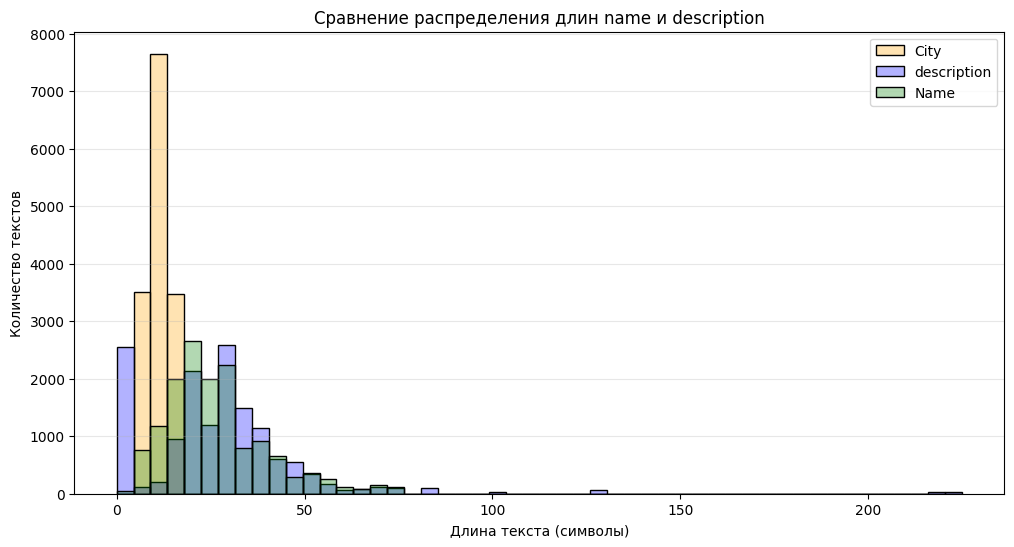

In [21]:
# Зададим данные
city_lengths = df['City'].str.len().fillna(0)
name_lengths = df['Name'].str.len().fillna(0)
description_lengths = df['description'].str.len().fillna(0)

# Определим общие границы бинов на основе description
bin_edges = np.histogram_bin_edges(description_lengths, bins=50)  # или bins='auto'

plt.figure(figsize=(12, 6))


# Построим гистограмму для City (оранжевая)
sns.histplot(
    city_lengths,
    bins=bin_edges,
    color='orange',
    alpha=0.3,
    label='City',
    kde=False,
)

# Добавим гистограмму для Description (синяя)
sns.histplot(
    description_lengths,
    bins=50,  # те же самые бины!
    color='blue',
    alpha=0.3,
    label='description',
    kde=False,
)

# Добавим гистограмму для Name (зеленая)
sns.histplot(
    name_lengths,
    bins=bin_edges,
    color='green',
    alpha=0.3,
    label='Name',
    kde=False,
)


# Настроим график
plt.title('Сравнение распределения длин name и description')
plt.xlabel('Длина текста (символы)')
plt.ylabel('Количество текстов')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

## **Посмотрим какие есть города**

In [16]:
unique_cities_count = df['City'].nunique()
print(f"Количество уникальных городов: {unique_cities_count}")
unique_cities_list = df['City'].unique()
print(f"Список уникальных городов (первые 10):\n{unique_cities_list[:10]}")  # Вывод первых 10 для примера

Количество уникальных городов: 4
Список уникальных городов (первые 10):
['Екатеринбург' 'Нижний Новгород' 'Владимир' 'Ярославль']


### У нас всего 4 города

In [17]:
# Компилируем регулярное выражение для поиска русских букв (включая ё и Ё)
russian_pattern = re.compile(r'[а-яА-ЯёЁ]')

# Применяем функцию к указанным полям
for column in ['City', 'Name', 'description']:
    # Создаем маску для значений без русских букв
    mask = df[column].apply(has_no_russian)

    # Заменяем значения на пустую строку
    df.loc[mask, column] = ''

## **Объеденим поля для RAG модели**

In [18]:
# Конкатенация полей для RAG
df['combined_text'] = df['City'] + ' ' + df['Name'] + ' ' + df['description']

## **Количество уникальных полей**

In [19]:
unique_count = df['combined_text'].nunique()
print(f"Количество уникальных значений в combined_text: {unique_count}")

Количество уникальных значений в combined_text: 320


## **Удалим пустые значения "combined_text"**

In [20]:
df = df[df['combined_text'].notna()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12078 entries, 0 to 14633
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     12078 non-null  int64  
 1   Name           12078 non-null  object 
 2   WikiData       12078 non-null  object 
 3   City           12078 non-null  object 
 4   Lon            12078 non-null  float64
 5   Lat            12078 non-null  float64
 6   description    12078 non-null  object 
 7   image          12078 non-null  object 
 8   en_txt         12078 non-null  object 
 9   combined_text  12078 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 1.0+ MB


## **Оставим самые длинные описани для en_text и сгруппируем по сombined_text**

In [21]:
rows_list = []
for _, group in df.groupby('combined_text'):
    max_idx = group['en_txt'].str.len().idxmax()
    rows_list.append(group.loc[max_idx])

df_cleaned = pd.DataFrame(rows_list).reset_index(drop=True)

In [22]:
df_cleaned.head()

Unnamed: 0                                         Name   WikiData  \
0         991                                               Q18331756   
1          71                     Авиамеханический колледж  Q18786015   
2         736   Белокаменные памятники Владимира и Суздаля    Q838264   
3         533  Богородице-Рождественский мужской монастырь   Q4089667   
4         405                    Бывшая водонапорная башня   Q4114100   

       City        Lon        Lat  \
0  Владимир  40.456497  56.154667   
1  Владимир  40.387318  56.126278   
2  Владимир  40.416698  56.150002   
3  Владимир  40.414005  56.131298   
4  Владимир  40.398781  56.125111   

                                      description  \
0          Армянская церковь в г. Владимир России   
1           Владимирский авиамеханический колледж   
2      Белокаменные памятники Владимира и Суздаля   
3  Богородице-Рождественский монастырь (Владимир)   
4              достопримечательность во Владимире   

                                               image  \
0  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...   
1  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...   
2  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...   
3  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...   
4  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...   

                                              en_txt  \
0  a computer generated image of a rocky landscap...   
1  there are many people sitting in a classroom w...   
2  a bunch of pictures of different buildings and...   
3  arafed image of a church with a cross and a ch...   
4  nighttime view of a building with a clock towe...   

                                       combined_text  
0   Владимир  Армянская церковь в г. Владимир России  
1  Владимир Авиамеханический колледж Владимирский...  
2  Владимир Белокаменные памятники Владимира и Су...  
3  Владимир Богородице-Рождественский мужской мон...  
4  Владимир Бывшая водонапорная башня достопримеч...

In [23]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     320 non-null    int64  
 1   Name           320 non-null    object 
 2   WikiData       320 non-null    object 
 3   City           320 non-null    object 
 4   Lon            320 non-null    float64
 5   Lat            320 non-null    float64
 6   description    320 non-null    object 
 7   image          320 non-null    object 
 8   en_txt         320 non-null    object 
 9   combined_text  320 non-null    object 
dtypes: float64(2), int64(1), object(7)
memory usage: 25.1+ KB


In [24]:
df_cleaned.to_csv('df_cleaned.csv', index=False)

## **Изучим распределение длины описания и текста для картинок**

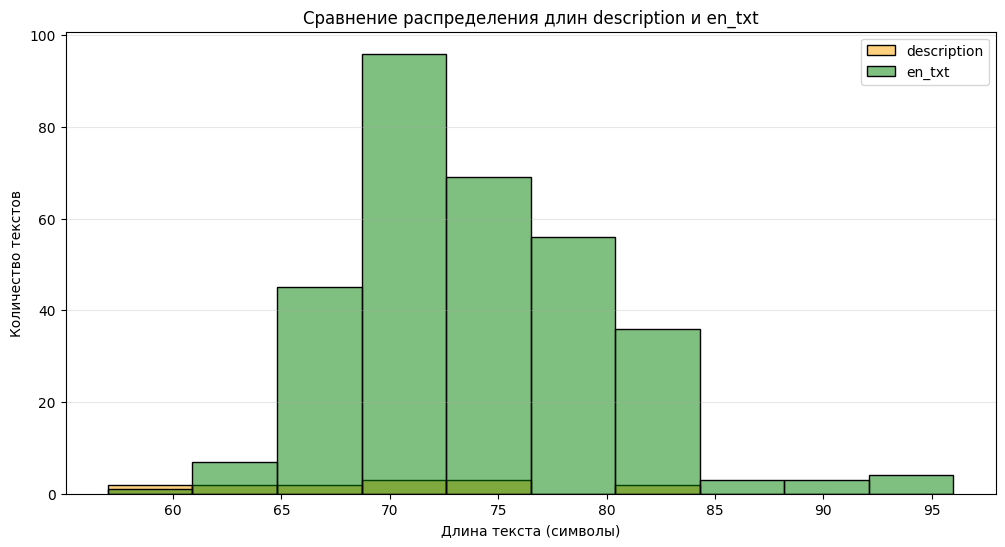

In [25]:
# Зададим данные
description = df_cleaned['description'].str.len().fillna(0)
en_lengths = df_cleaned['en_txt'].str.len().fillna(0)

# Определим общие границы бинов на основе en_txt
bin_edges = np.histogram_bin_edges(en_lengths, bins=10)  # или bins='auto'

plt.figure(figsize=(12, 6))

# Добавим гистограмму для description (оранжевая)
sns.histplot(
    description,
    bins=bin_edges,  # те же самые бины!
    color='orange',
    alpha=0.5,
    label='description',
    kde=False,
)

# Построим гистограмму для en_txt (зелёная)
sns.histplot(
    en_lengths,
    bins=bin_edges,  # используем ОДИНАКОВЫЕ БИНЫ
    color='green',
    alpha=0.5,
    label='en_txt',
    kde=False,
)

# Настроим график
plt.title('Сравнение распределения длин description и en_txt')
plt.xlabel('Длина текста (символы)')
plt.ylabel('Количество текстов')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

## **Для описания картинок сделаем перевод**

Преведём строку en_txt на русский ru_txt


In [26]:
# Инициализация переводчика
translator = Translator()

# Создаем список для хранения переводов
translations = []

# Прогресс-бар для визуализации
for text in tqdm(df_cleaned['en_txt'], desc="Перевод текста"):
    try:
        # Синхронный перевод (без async/await)
        translation = await translator.translate(text, src='en', dest='ru')
        translations.append(translation.text)
    except Exception as e:
        print(f"\nОшибка перевода: {e}")

# Добавляем переводы в DataFrame
df_cleaned['ru_txt'] = translations

# Выводим примеры перевода
print("\nПримеры перевода:")
print(df_cleaned[['en_txt', 'ru_txt']].head(3))

Перевод текста:   0%|          | 0/320 [00:00<?, ?it/s]


Примеры перевода:
                                              en_txt  \
0  a computer generated image of a rocky landscap...   
1  there are many people sitting in a classroom w...   
2  a bunch of pictures of different buildings and...   

                                              ru_txt  
0  компьютерное изображение скалистого ландшафта ...  
1  В классе сидит много людей за партами, а впере...  
2  куча фотографий разных зданий и архитектуры в ...  


### **Сохраним результат**

In [27]:
df_cleaned.to_csv('df_translate.csv', index=False)

### **Посмотрим на распределение длины текста**

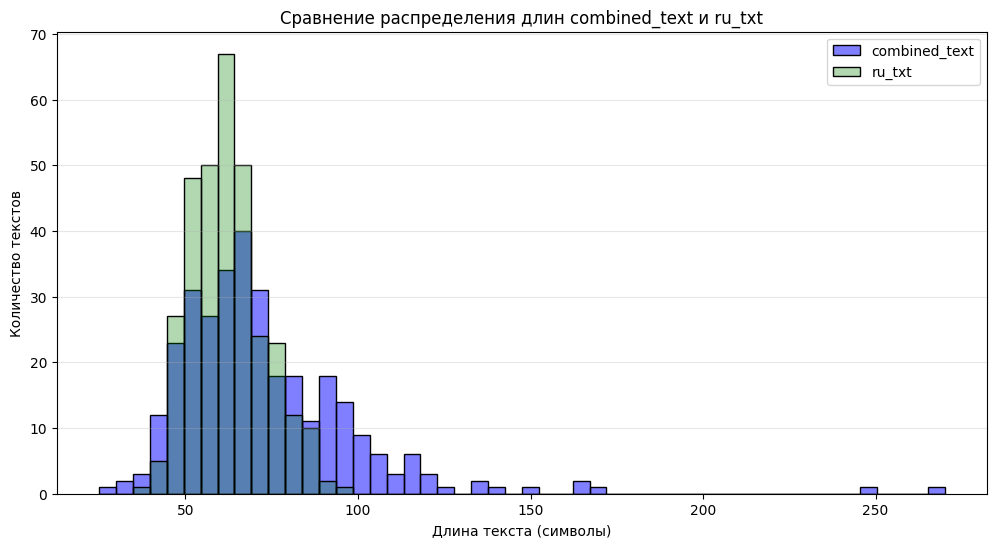

In [28]:
# Зададим данные
combined_lengths = df_cleaned['combined_text'].str.len().fillna(0)
ru_lengths = df_cleaned['ru_txt'].str.len().fillna(0)

# Определим общие границы бинов на основе combined_text
bin_edges = np.histogram_bin_edges(combined_lengths, bins=50)  # или bins='auto'

plt.figure(figsize=(12, 6))

# Построим гистограмму для combined_text (синяя)
sns.histplot(
    combined_lengths,
    bins=bin_edges,  # используем ОДИНАКОВЫЕ БИНЫ
    color='blue',
    alpha=0.5,
    label='combined_text',
    kde=False,
)

# Добавим гистограмму для ru_txt (зеленая)
sns.histplot(
    ru_lengths,
    bins=bin_edges,  # те же самые бины!
    color='green',
    alpha=0.3,
    label='ru_txt',
    kde=False,
)

# Настроим график
plt.title('Сравнение распределения длин combined_text и ru_txt')
plt.xlabel('Длина текста (символы)')
plt.ylabel('Количество текстов')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

In [33]:
df_cleaned = pd.read_csv('df_translate.csv')

In [34]:
df_cleaned.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     320 non-null    int64  
 1   Name           316 non-null    object 
 2   WikiData       320 non-null    object 
 3   City           320 non-null    object 
 4   Lon            320 non-null    float64
 5   Lat            320 non-null    float64
 6   description    320 non-null    object 
 7   image          320 non-null    object 
 8   en_txt         320 non-null    object 
 9   combined_text  320 non-null    object 
 10  ru_txt         320 non-null    object 
dtypes: float64(2), int64(1), object(8)
memory usage: 27.6+ KB


In [35]:
df_cleaned.head()

Unnamed: 0                                         Name   WikiData  \
0         991                                          NaN  Q18331756   
1          71                     Авиамеханический колледж  Q18786015   
2         736   Белокаменные памятники Владимира и Суздаля    Q838264   
3         533  Богородице-Рождественский мужской монастырь   Q4089667   
4         405                    Бывшая водонапорная башня   Q4114100   

       City        Lon        Lat  \
0  Владимир  40.456497  56.154667   
1  Владимир  40.387318  56.126278   
2  Владимир  40.416698  56.150002   
3  Владимир  40.414005  56.131298   
4  Владимир  40.398781  56.125111   

                                      description  \
0          Армянская церковь в г. Владимир России   
1           Владимирский авиамеханический колледж   
2      Белокаменные памятники Владимира и Суздаля   
3  Богородице-Рождественский монастырь (Владимир)   
4              достопримечательность во Владимире   

                                               image  \
0  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...   
1  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...   
2  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...   
3  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...   
4  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...   

                                              en_txt  \
0  a computer generated image of a rocky landscap...   
1  there are many people sitting in a classroom w...   
2  a bunch of pictures of different buildings and...   
3  arafed image of a church with a cross and a ch...   
4  nighttime view of a building with a clock towe...   

                                       combined_text  \
0   Владимир  Армянская церковь в г. Владимир России   
1  Владимир Авиамеханический колледж Владимирский...   
2  Владимир Белокаменные памятники Владимира и Су...   
3  Владимир Богородице-Рождественский мужской мон...   
4  Владимир Бывшая водонапорная башня достопримеч...   

                                              ru_txt  
0  компьютерное изображение скалистого ландшафта ...  
1  В классе сидит много людей за партами, а впере...  
2  куча фотографий разных зданий и архитектуры в ...  
3  Арафедное изображение церкви с крестом и церкв...  
4  ночной вид на здание с башней с часами посреди...

### **Теперь мы можем искать не только по тексту, но и по описанию картинок**

## **Очистка от выбросов методом кластеризации векторов TF-IDF**

В данных есть выбросы — записи, не относящихся к туристическим или историческим объектам. Для очистки данных можно, например, использовать алгоритм TF-IDF: создаем корпус текстов из описаний, применяем TF-IDF, извлекаем наиболее редко или часто встречающиеся слова. Они могут указывать на мусорные данные, такие как мемы, баннеры или личные фото людей. После выделения подозрительных паттернов, можно провести ручную проверку и фильтрацию данных.

### **Векторизация текста**

In [36]:
# Скачиваем стоп-слова (выполняется один раз)
nltk.download('stopwords')

# Получаем русские стоп-слова
russian_stop_words = stopwords.words('russian')

[nltk_data] Downloading package stopwords to /home/ded/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [37]:
# Создание векторайзера TF-IDF
vectorizer = TfidfVectorizer(
    preprocessor=preprocess,
    stop_words=russian_stop_words,
    max_features=5000  # Ограничиваем количество уникальных слов = 5 000
)

# Преобразование текстов в матрицу TF-IDF
X = vectorizer.fit_transform(df_cleaned['combined_text'])

### **Кластеризация K-Means**

In [38]:
# Эмпирически выбираем число кластеров (можно попробовать 3-5)
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X)

### **Анализ кластеров**

In [39]:
for i in range(n_clusters):
    cluster_texts = df_cleaned[clusters == i]['combined_text']
    words = ' '.join(cluster_texts).split()
    common_words = Counter(words).most_common(20)
    print(f"Cluster {i} common words:", common_words)

Cluster 0 common words: [('музей', 23), ('Музей', 20), ('в', 17), ('Екатеринбург', 16), ('Екатеринбурге', 9), ('Ярославль', 8), ('и', 6), ('Дом-музей', 5), ('дом-музей', 5), ('истории', 5), ('Владимир', 4), ('музей-заповедник', 4), ('Мемориальный', 4), ('М.', 4), ('Урала', 4), ('Нижний', 4), ('Новгород', 4), ('художественный', 4), ('Н.', 3), ('искусства', 3)]
Cluster 1 common words: [('Екатеринбург', 61), ('в', 42), ('Екатеринбурге', 40), ('Дом', 29), ('здание', 14), ('Здание', 12), ('Усадьба', 8), ('и', 6), ('улица', 6), ('памятник', 5), ('(Екатеринбург)', 4), ('контор', 4), ('Чувильдина', 4), ('мост', 4), ('Памятник', 4), ('И.', 4), ('городской', 3), ('купца', 3), ('училище', 3), ('им.', 3)]
Cluster 2 common words: [('Ярославль', 56), ('в', 46), ('Ярославле', 33), ('храм', 31), ('Владимир', 18), ('монастырь', 17), ('Храм', 15), ('Православный', 14), ('(Ярославль)', 13), ('Церковь', 9), ('церковь', 8), ('православный', 8), ('во', 6), ('кладбище', 6), ('Владимирский', 5), ('на', 5), ('

### **Визуализация кластеров**

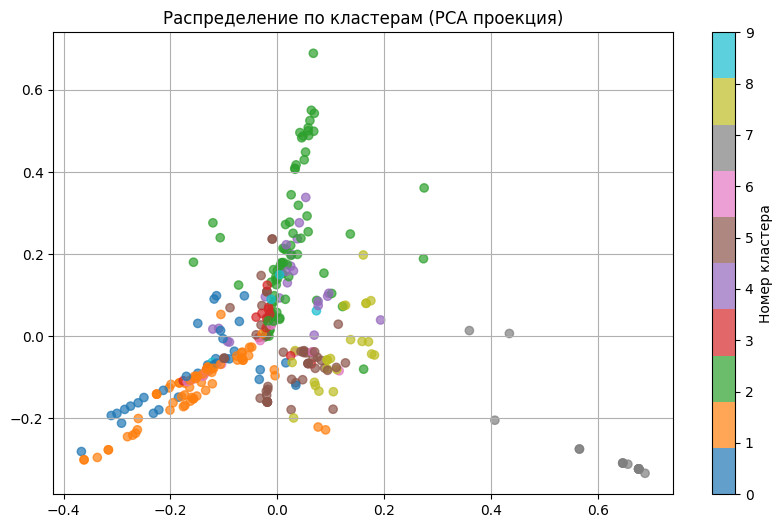

In [40]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='tab10', alpha=0.7)
plt.title('Распределение по кластерам (PCA проекция)')
plt.colorbar(label='Номер кластера')
plt.grid(True)
plt.show()

### **Вызывает вопрос 7 кластер. Изучим кластеры внимательно.**

In [41]:
df_cleaned['cluster'] = kmeans.fit_predict(X)

# Выводим результаты
print_cluster_samples(df_cleaned)


АНАЛИЗ 9 КЛАСТЕРОВ (всего документов: 320)

КЛАСТЕР #0 (документов: 32)
------------------------------
Ярославль Музыка и время Частный музей
Екатеринбург Свердловский областной краеведческий музей Свердловский областной краеведческий музей
Ярославль Мемориальный дом-музей М. Богдановича Мемориальный дом-музей М. Богдановича
Екатеринбург Художественный Музей Эрнста Неизвестного музей в Екатеринбурге
Екатеринбург Екатеринбургский музей изобразительных искусств музей в Екатеринбурге

КЛАСТЕР #1 (документов: 65)
------------------------------
Екатеринбург улица Февральской Революции улица в Екатеринбурге
Екатеринбург №29 Дом В.И. Чувильдина Дом купца Чувильдина
Владимир Здание Присутственных мест. "Палаты" Здание присутственных мест
Екатеринбург Усадьба ротмистра Переяславцева Усадьба ротмистра Переяславцева
Екатеринбург Второй Дом Советов Второй Дом Советов (Екатеринбург)

КЛАСТЕР #2 (документов: 81)
------------------------------
Ярославль Богоявленская башня Православный храм в Яросла

7 кластер - это башни, всё нормально, но есть вопросы к вот таким описаниям:
  - "Екатеринбург улица Февральской Революции улица в Екатеринбурге"
  - "Владимир Авиамеханический колледж Владимирский авиамеханический колледж"
  - "Ярославль Бутусовский посёлок Бутусовский посёлок"
  - "№29 Дом В.И. Чувильдина Дом купца Чувильдина"

Оставлю эти данные т.к. возможно они имеют культурно - историческую ценность.

# **Изображения**

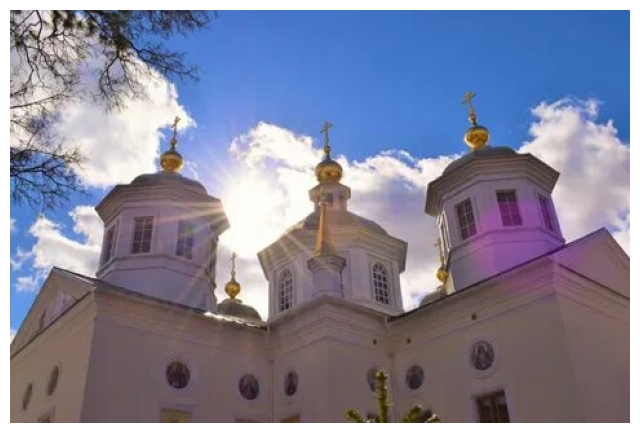

In [40]:
get_image(df_cleaned.sample(1)['image'].tolist()[0])

Для дальнейшего тестирования и получения чистых сэмплов, возьмем 100 чистых образцов со стратификацией по городу и названию места. Это можно сделать, выбрав случайным образом несколько образцов из каждой категории (город + название места), чтобы обеспечить равномерное представительство и разнообразие данных.

**!! Важно:** Помните, что чистые сэмплы одного и того же места выдадут примерно одинаковое описание. Есть несколько стратегий, как повысить разнообразие ответов:

- выбор одного самого лучшего:
  - самое длинное описание
  - смое подходящие по мнению LLM
- конкатенация описаний (но важно не сконкатенировать слишком много)

Изображения можно отдать в мета-данные.

# **Подход к построению RAG**

Анализ данных показал, что текст у нас очень короткий.

  - разбивать текст на чанки не имеет смысла;
  
  - для векторизации объединим используем поле **'combined_text'**, которое мы создали из 3х полей **'City', 'Name', 'description'**
  
  - отдельно создадим вектора для поиска по текстовому описанию картинок на русском языке **'ru_txt
  
  - будем использовать в качестве векторизатора **BAAI/bge-m3**;
  
  - в качестве реранкера **BAAI/bge-reranker-v2-m3**;
  
  - в качестве векторной базы данных будем использовать **faiss**;

  - LLM - кванотванная модель **Llama t-pro-it-1.0-q4_k_s.gguf**
  
  - установим порог косинусной близости, выше которого модель будет сообщать - что в базе данных нет информации по объекту.

## **Создаём 2 датасета - для поиска по описанию и по картинкам и объединяем их в один**

In [41]:
# Создаем копии исходных датафреймов, сохраняя все нужные поля
df_combined = df_cleaned[["combined_text", "image", "City", "Lon", "Lat"]].copy()
df_combined["text"] = df_combined["combined_text"]  # создаем колонку text из combined_text
df_combined["text_type"] = "main"  # метка типа текста

df_image = df_cleaned[["ru_txt", "image", "City", "Lon", "Lat"]].copy()
df_image.rename(columns={"ru_txt": "text"}, inplace=True)
df_image["text_type"] = "image"  # метка типа текста
df_image["combined_text"] = df_cleaned["combined_text"]  # добавляем combined_text из исходного датафрейма

# Объединяем в один DataFrame (640 строк)
df_2 = pd.concat([df_combined, df_image], ignore_index=True)

In [42]:
df_2.to_csv('df_faiss.csv', index=False)

In [43]:
df_2 = pd.read_csv('df_faiss.csv')

In [44]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   combined_text  640 non-null    object 
 1   image          640 non-null    object 
 2   City           640 non-null    object 
 3   Lon            640 non-null    float64
 4   Lat            640 non-null    float64
 5   text           640 non-null    object 
 6   text_type      640 non-null    object 
dtypes: float64(2), object(5)
memory usage: 35.1+ KB


# **Создаём класс модели**

In [5]:
RAG = RagModel()

llama_context: n_ctx_per_seq (2048) < n_ctx_train (32768) -- the full capacity of the model will not be utilized


## **Проверим работу экземпляра класса**

In [55]:
texts = ["Пример текста 1", "Пример текста 2"]
embeddings = RAG.get_embeddings(texts)
print("Размерность эмбеддингов:", len(embeddings[0]))  # Должно быть 1024 для bge-m3

Размерность эмбеддингов: 1024


In [56]:
text = RAG.generate_text('Что такое метрика Faithfulness')
print(text)

Faithfulness — это метрика, используемая в области объяснимого ИИ (Explainable AI), которая оценивает, насколько объяснение модели соответствует её внутренним процессам принятия решений. Эта метрика важна для оценки качества объяснений, которые предоставляются для моделей машинного обучения, особенно для сложных моделей, таких как глубокие нейронные сети. Основные аспекты метрики Faithfulness включают: 1. **Соответствие предсказаниям модели**: Faithfulness измеряет, насколько объяснение точно отражает вклад различных признаков в окончательное предсказание модели. Если объяснение сильно отклоняется от фактического поведения модели, оно считается менее Faithful. 2. **Чувствительность к изменениям входных данных**: Хорошее объяснение должно быть чувствительным к изменениям входных данных, которые влияют на предсказание модели. Если небольшие изменения в данных приводят к значительным изменениям в предсказании, но объяснение остаётся неизменным, это указывает на низкую Faithfulness. 3. **С

### **Посмотрим как модель следует инструкциям и можно ли этой моделью почистить датасет**

In [58]:
source_text = "Ярославль Николо-Тропинская церковь Церковь в Ярославле"
prompt = f"Перепиши следующее предложение, устранив повторы и сделав его более лаконичным:\n'f{source_text}'\nНичего не добавляй от себя"
text = RAG.generate_text(source_text)
print(text)

Николо-Тропинская церковь в Ярославле — это одна из самых известных и красивых церквей города, расположенная на Тропининском переулке. Вот несколько ключевых фактов о ней: 1. **История**: Церковь была построена в 1770-1773 годах по проекту архитектора Ивана Зарудного. Она была возведена на месте более ранней деревянной церкви, посвященной святому Николаю. 2. **Архитектура**: Здание выполнено в стиле классицизма с элементами барокко. Церковь имеет характерный для того времени облик с колоннами, фронтоном и куполом. 3. **Интерьер**: Внутри церкви сохранились росписи XVIII века, которые считаются одними из лучших образцов ярославской школы живописи. Также здесь находятся иконы и церковная утварь. 4. **Современное состояние**: В советское время церковь была закрыта, но в 1990-х годах она была возвращена верующим и восстановлена. Сегодня Николо-Тропинская церковь является действующей и популярной среди туристов достопримечательностью Ярославля. 5. **Праздники и мероприятия**: В церкви прово

### Модель не следует инструкциям. Переведём  модель в режим чата, служебный промт добавим в system

In [59]:
messages = [
    {"role": "system", "content": "Ты бот копирайтер, твоя задача - просто переписать красиво и лаконично текст, убрав повторы и ничего не добавляя от себя"},
    {"role": "user", "content": "Ярославль Николо-Тропинская церковь Церковь в Ярославле"},
]

text = RAG.chat(messages)
print(text)

Николо-Тропинская церковь в Ярославле.


### **Вот теперь модель  следует инструкциям**

## **Финальная чистка датасета с  помощью LLM**

In [61]:
df_2.loc[df_2['text_type'] == 'main', 'text'] = df_2.loc[df_2['text_type'] == 'main', 'combined_text']

In [62]:
df_2.to_csv('df_final.csv', index=False)

### **Итоговый датасет**

In [6]:
df_result = pd.read_csv('df_final.csv')

In [7]:
df_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   combined_text  640 non-null    object 
 1   image          640 non-null    object 
 2   City           640 non-null    object 
 3   Lon            640 non-null    float64
 4   Lat            640 non-null    float64
 5   text           640 non-null    object 
 6   text_type      640 non-null    object 
dtypes: float64(2), object(5)
memory usage: 35.1+ KB


In [8]:
df_result.head()

combined_text  \
0  Владимирская Армянская церковь в городе Владим...   
1              Владимирский авиамеханический колледж   
2        Белокаменные памятники Владимира и Суздаля.   
3  Мужской монастырь Рождества Богородицы в Влади...   
4  Водонапорная башня во Владимире — известная до...   

                                               image      City        Lon  \
0  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...  Владимир  40.456497   
1  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...  Владимир  40.387318   
2  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...  Владимир  40.416698   
3  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...  Владимир  40.414005   
4  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...  Владимир  40.398781   

         Lat                                               text text_type  
0  56.154667  Владимирская Армянская церковь в городе Владим...      main  
1  56.126278              Владимирский авиамеханический колледж      main  
2  56.150002        Белокаменные памятники Владимира и Суздаля.      main  
3  56.131298  Мужской монастырь Рождества Богородицы в Влади...      main  
4  56.125111  Водонапорная башня во Владимире — известная до...      main

In [9]:
df_result[df_result['text_type'] == 'image'].head(10)

combined_text  \
320  Владимирская Армянская церковь в городе Владим...   
321              Владимирский авиамеханический колледж   
322        Белокаменные памятники Владимира и Суздаля.   
323  Мужской монастырь Рождества Богородицы в Влади...   
324  Водонапорная башня во Владимире — известная до...   
325  Владимиро-Суздальский музей-заповедник (центра...   
326                    Владимирская духовная семинария   
327        Митрополия Владимира и Владимирский кремль.   
328  Академический областной драматический театр го...   
329  Владимирский государственный гуманитарный унив...   

                                                 image      City        Lon  \
320  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...  Владимир  40.456497   
321  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...  Владимир  40.387318   
322  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...  Владимир  40.416698   
323  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...  Владимир  40.414005   
324  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...  Владимир  40.398781   
325  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...  Владимир  40.409889   
326  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...  Владимир  40.413074   
327  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...  Владимир  40.414703   
328  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...  Владимир  40.396076   
329  /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...  Владимир  40.379169   

           Lat                                               text text_type  
320  56.154667  компьютерное изображение скалистого ландшафта ...     image  
321  56.126278  В классе сидит много людей за партами, а впере...     image  
322  56.150002  куча фотографий разных зданий и архитектуры в ...     image  
323  56.131298  Арафедное изображение церкви с крестом и церкв...     image  
324  56.125111  ночной вид на здание с башней с часами посреди...     image  
325  56.130569  вид с воздуха на большую белую церковь с голуб...     image  
326  56.131168   есть черно-белое фото здания с лошадью и каретой     image  
327  56.131302  Арафированный мужчина с белой бородой и сине-з...     image  
328  56.125618  люди идут перед зданием с башней с часами на з...     image  
329  56.146389  люди идут перед зданием с табличкой «Инженерны...     image

### **Создаём нашу финальную базу данных**

In [10]:
RAG.create_documents(df_result)

### **Проверка работы поиска k-top=20 векторов**

In [11]:
text = 'Крепость с башнями'
docs_1 = RAG.similarity_search(text)
for doc, score in docs_1:
    print(f"ID: {doc.id}")
    print(f"Близкий текст: {doc.page_content}")
    print(f"Описанее: {doc.metadata['combined_text']}")
    print(f"Тип текста: {doc.metadata['text_type']}")
    print(f"Расстояние: {score}")
    print("-----")

ID: f86498f7-98b4-4ca8-8d56-627c7c3903ee
Близкий текст: старая фотография большого здания с двумя башнями и крестом наверху
Описанее: Николо-Тропинская церковь в Ярославле.
Тип текста: image
Расстояние: 0.569798469543457
-----
ID: 8cd9ffd6-61b2-42f7-add1-22e2395e53f6
Близкий текст: ночной вид на длинную лестницу, ведущую к замку с башней с часами
Описанее: Чкаловская лестница в Нижнем Новгороде: лестница на Волжском откосе.
Тип текста: image
Расстояние: 0.6444437503814697
-----
ID: 13510df2-ef1d-4011-acb1-9faa576ed8a8
Близкий текст: большое здание с башней, стоящее на вершине заснеженного поля
Описанее: Владимирский Дмитриевский собор — православный храм во Владимире.
Тип текста: image
Расстояние: 0.6445989608764648
-----
ID: 558a36b0-c761-4b12-a23e-d9bb3601a95b
Близкий текст: посреди леса стоит небольшое деревянное здание с двумя башнями
Описанее: Церковь великомученика Димитрия Солунского, также известная как Смоленская, в Ярославле.
Тип текста: image
Расстояние: 0.6486039161682129
-

In [12]:
text = 'Достопримечаеельности Ярославля'
docs_2 = RAG.similarity_search(text)
for doc, score in docs_2:
    print(f"ID: {doc.id}")
    print(f"Близкий текст: {doc.page_content}")
    print(f"Описанее: {doc.metadata['combined_text']}")
    print(f"Тип текста: {doc.metadata['text_type']}")
    print(f"Расстояние: {score}")
    print("-----")

ID: 71c7ffa4-b95c-41b1-8d65-b43315054a56
Близкий текст: Исторический центр Ярославля
Описанее: Исторический центр Ярославля
Тип текста: main
Расстояние: 0.4438804090023041
-----
ID: 5143d806-223b-4a54-859a-41e5ac0005c4
Близкий текст: Музей истории города Ярославля
Описанее: Музей истории города Ярославля
Тип текста: main
Расстояние: 0.46814465522766113
-----
ID: 2c56cbd5-ffc0-4115-a480-2e4d551c69c4
Близкий текст: Архитектурный ансамбль Ярославля
Описанее: Архитектурный ансамбль Ярославля
Тип текста: main
Расстояние: 0.5012335777282715
-----
ID: 59a218a3-72c4-4f63-bb2c-fe02616c54c2
Близкий текст: Ярославский музей-заповедник в Ярославле.
Описанее: Ярославский музей-заповедник в Ярославле.
Тип текста: main
Расстояние: 0.5659133195877075
-----
ID: 34bdf797-bd2f-45c7-b4f5-062b1cb361fb
Близкий текст: Петропавловский парк в Ярославле
Описанее: Петропавловский парк в Ярославле
Тип текста: main
Расстояние: 0.618860125541687
-----
ID: 895cd07c-acb6-4e7b-857f-253b58ca834e
Близкий текст: Парк 100

### **Проверка работы реранкера**

In [13]:
query = 'Крепость с башнями'
reranked_docs_1 = RAG.rerank_documents(query, docs_1, top_k=10)

for doc, score in reranked_docs_1:
    print(f"ID: {doc.id}")
    print(f"Близкий текст: {doc.page_content}")
    print(f"Описанее: {doc.metadata['combined_text']}")
    print(f"Тип текста: {doc.metadata['text_type']}")
    print(f"Расстояние: {score}")
    print("-----")

You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


ID: f86498f7-98b4-4ca8-8d56-627c7c3903ee
Близкий текст: старая фотография большого здания с двумя башнями и крестом наверху
Описанее: Николо-Тропинская церковь в Ярославле.
Тип текста: image
Расстояние: -0.05550994724035263
-----
ID: 5859e670-1bcc-4401-a23d-4ffe1ca2c458
Близкий текст: есть небольшое деревянное здание с белым забором и башней с часами
Описанее: Церковь Преображения Господня, также известная как Спасо-Преображенская церковь в Старых Печёрах, Нижний Новгород.
Тип текста: image
Расстояние: -0.64634108543396
-----
ID: 558a36b0-c761-4b12-a23e-d9bb3601a95b
Близкий текст: посреди леса стоит небольшое деревянное здание с двумя башнями
Описанее: Церковь великомученика Димитрия Солунского, также известная как Смоленская, в Ярославле.
Тип текста: image
Расстояние: -0.6711920499801636
-----
ID: 09b670ff-c85c-4755-b10a-467673484a72
Близкий текст: есть большое белое здание с башней с часами посередине.
Описанее: Преображенская церковь на Уктусе в Екатеринбурге.
Тип текста: image
Расс

In [14]:
query = 'Достопримечаеельности Ярославля'
reranked_docs_2 = RAG.rerank_documents(query, docs_2, top_k=5)

for doc, score in reranked_docs_2:
    print(f"ID: {doc.id}")
    print(f"Близкий текст: {doc.page_content}")
    print(f"Описанее: {doc.metadata['combined_text']}")
    print(f"Тип текста: {doc.metadata['text_type']}")
    print(f"Расстояние: {score}")
    print("-----")

ID: d3909644-02c5-4371-985c-8dad48fde967
Близкий текст: В Ярославле расположены Знаменская церковь и Крепостная башня.
Описанее: В Ярославле расположены Знаменская церковь и Крепостная башня.
Тип текста: main
Расстояние: 2.566762924194336
-----
ID: 9e5db46a-9365-4d38-9420-fb9324be65e7
Близкий текст: Волжская башня в Ярославле.
Описанее: Волжская башня в Ярославле.
Тип текста: main
Расстояние: 0.20015057921409607
-----
ID: 34bdf797-bd2f-45c7-b4f5-062b1cb361fb
Близкий текст: Петропавловский парк в Ярославле
Описанее: Петропавловский парк в Ярославле
Тип текста: main
Расстояние: -1.2083070278167725
-----
ID: 7e8ce417-1667-42d0-89c2-e9c0e7afd2e9
Близкий текст: Православный храм в Ярославле.
Описанее: Православный храм в Ярославле.
Тип текста: main
Расстояние: -1.249861717224121
-----
ID: 24fd94e8-ba5c-4609-ab56-e2075365686f
Близкий текст: Церковь Рождества Христова в Ярославле.
Описанее: Церковь Рождества Христова в Ярославле.
Тип текста: main
Расстояние: -1.381157398223877
-----


### **Создаём эмбеддинги**

In [15]:
# Преобразуем тексты в эмбеддинги
texts = df_result["text"].tolist()
embeddings = RAG.get_embeddings(texts)

In [16]:
len(embeddings)

640

### **Визуализация эмбеддингов**
Выполним визуализацию эмбеддингов при помощи метода главных компонент (PCA) и Uniform Manifold Approximation and Projection (UMAP). Выполним PCA независимо от pacmap.

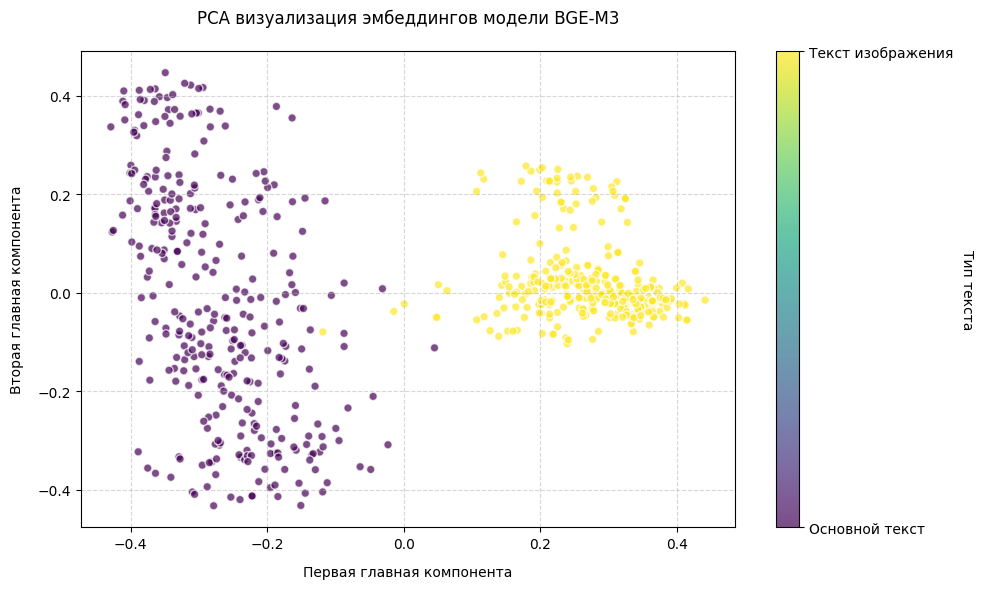

In [17]:
# Создаем объект PCA с 2 компонентами
pca = PCA(n_components=2)

# Применяем PCA к эмбеддингам (преобразуем 1024D -> 2D)
embeddings_pca = pca.fit_transform(embeddings)

# Определяем метки для двух типов текстов
# 320 эмбеддингов основного текста и 320 эмбеддингов текста изображений
text_labels = ["main_text"] * 320 + ["image_text"] * 320

# Создаем цветовую карту: 0 - main_text, 1 - image_text
color_mapping = [0 if label == "main_text" else 1 for label in text_labels]

# Настраиваем визуализацию
plt.figure(figsize=(10, 6))
scatter_plot = plt.scatter(
    x=embeddings_pca[:, 0],  # Первая главная компонента по оси X
    y=embeddings_pca[:, 1],  # Вторая главная компонента по оси Y
    c=color_mapping,         # Цвета точек согласно типам текста
    cmap="viridis",          # Цветовая схема
    alpha=0.7,               # Прозрачность точек
    edgecolors='w'           # Белые границы точек для лучшей видимости
)

# Настраиваем цветовую легенду
colorbar = plt.colorbar(scatter_plot, ticks=[0, 1])
colorbar.set_label('Тип текста', rotation=270, labelpad=15)
colorbar.set_ticklabels(['Основной текст', 'Текст изображения'])

# Добавляем подписи и заголовок
plt.title("PCA визуализация эмбеддингов модели BGE-M3", pad=20)
plt.xlabel("Первая главная компонента", labelpad=10)
plt.ylabel("Вторая главная компонента", labelpad=10)

# Опционально: добавляем сетку для лучшей читаемости
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()  # Автоматическая подгонка отступов
plt.show()

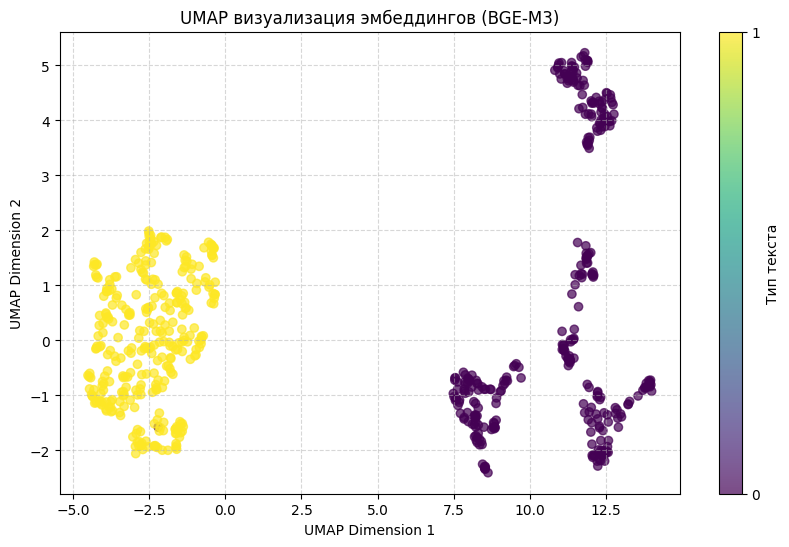

In [18]:
warnings.filterwarnings("ignore", category=FutureWarning, message="'force_all_finite' was renamed")
warnings.filterwarnings("ignore", category=UserWarning, module="umap")

# Создаем UMAP-reducer с 2 компонентами
reducer = umap.UMAP(
    n_components=2,  # 2D-проекция
    random_state=42  # Для воспроизводимости
)

# Применяем UMAP к эмбеддингам
embeddings_umap = reducer.fit_transform(embeddings)

plt.figure(figsize=(10, 6))
plt.scatter(
    embeddings_umap[:, 0],
    embeddings_umap[:, 1],
    c=[0 if label == "main_text" else 1 for label in text_labels],
    cmap="viridis",
    alpha=0.7
)

# Опционально: добавляем сетку для лучшей читаемости
plt.grid(True, linestyle='--', alpha=0.5)

plt.colorbar(ticks=[0, 1], label="Тип текста")
plt.title("UMAP визуализация эмбеддингов (BGE-M3)")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()

## **Выводы по визуализации векторов**
Видим четкие разделения вектора по основному тексту (фиолетовый) и описанию для картинок (жёлтый).

В основном описании мы видим отдельное разделение по городам и в эмбеддингах описания картинок мы тоже видим отдельные группы.

# **RAGAS**

RAGAS - это система, созданная для автоматической оценки эффективности модели RAG. Она представляет собой комплексный инструмент, способный оценить как качество извлечения информации, так и качество созданного текста. Это достигается благодаря использованию различных метрик, которые анализируют разные аспекты ответов, сгенерированных языковой моделью.



## Метрики оценки в RAGAS

### Faithfulness
Оценивает, насколько ответы языковой модели верно передают информацию, содержащуюся в источниках данных. Это критически важно, чтобы гарантировать, что модель не искажает или не меняет информацию при её интерпретации.

---

$
Faithfulness = \frac{\text{|Number of claims that can be inferred from given context|}}{\text{|Total number of claims in the generated answer|}}
$

### Answer Relevancy
Демонстрирует, насколько ответы соответствуют заданным вопросам. Это важный аспект, так как даже правильный ответ с технической точки зрения может быть ненужным, если он не отвечает на конкретный вопрос пользователя.

---

$\text{answer relevancy} = \frac{1}{N} \sum_{i=1}^{N} cos(E_{g_i}, E_o)$

$\text{answer relevancy} = \frac{1}{N} \sum_{i=1}^{N} \frac{E_{g_i} \cdot E_o}{\|E_{g_i}\|\|E_o\|}$

Где:

* $E_{g_i}$ - это эмбеддинг сгенерированного ответа $i$

* $E_o$ - это эмбеддинг исходного вопроса.

* $N$ - это количество сгенерированных вопросов, которое по умолчанию равно 3.

### Context Recall и Context Precision
Эти метрики измеряют эффективность модели в учете контекста вопроса для формирования ответа. "Context Recall" оценивает количество использованной информации из контекста в ответе, в то время как "Context Precision" оценивает точность и релевантность использования контекстной информации.

---

* $ \text{context recall} = \frac{\text{|GT sentences that can be attributed to context|}}{\text{|Number of sentences in GT|}} $
* $Context Precision@k = \frac{\sum \text{precision@k}}{\text{total number of relevant items in the top K results}}$
  * $Precision@k = \frac{\text {true positives@k}}{\text{(true positives@k + false positives@k)}}$

### Answer Semantic Similarity
Оценивает степень семантической близости между ответом модели и эталонным ответом. Это позволяет определить, насколько естественно и точно модель способна воссоздавать человеческий язык.

### Answer Correctness
Оценка корректности ответа. Это последний шаг в проверке, чтобы убедиться, предоставляет ли модель точную и достоверную информацию в своем ответе.

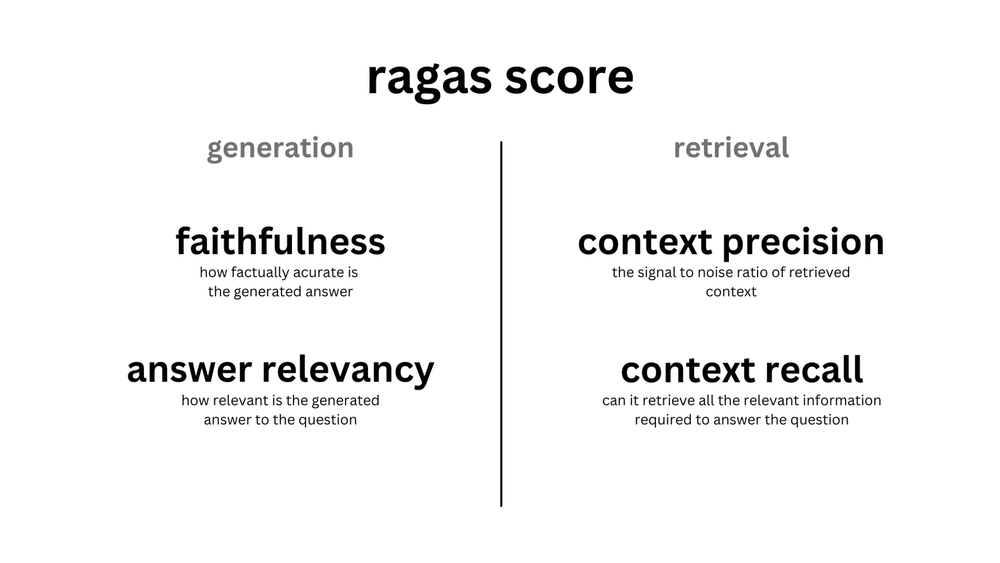

## Реализуем метрики Answer Relevancy и Answer Semantic Similarityв коде.

Для этого датасет нужно привести к виду, в котором будут следующие поля:

### 1. question
- Смысл: Эта колонка содержит вопросы, на которые нужно найти ответы. В контексте задач QA, это основная информация, которую модель должна обработать для генерации ответа.
- Пример: "Каковы преимущества RAG?"

### 2. ground_truths
- Смысл: В этой колонке находятся правильные ответы на соответствующие вопросы. Это может использоваться для оценки производительности модели, так как позволяет сравнить сгенерированные ответы с эталонными.
- Пример: "RAG улучшает качество генерации, используя внешние источники информации."

### 3. answer
- Смысл: Эта колонка содержит ответы, которые генерирует модель на основе заданных вопросов. Это может быть результат работы модели, которую вы тестируете или обучаете.
- Пример: "RAG позволяет моделям извлекать информацию из внешних источников, что улучшает их способность отвечать на сложные вопросы."

### 4. contexts
- Смысл: Эта колонка предоставляет контекст или дополнительную информацию, которая может быть полезна для понимания вопроса или для формирования ответа. Это может быть текст, из которого был извлечен ответ, или другие релевантные документы.
- Пример: "RAG (Retrieval-Augmented Generation) — это метод, который использует внешние базы данных для получения информации при генерации текста."

HINT: Поле question можно тоже сгенерировать. Например, можно попросить модель задать вопрос по описанию изображения.

HINT: Для answer_relevancy нужны не все поля

HINT: Инференс такого эксперимента может быть долгим. План минимум: возьмем 100 случайных сэмплов.

## **Создадим тестовый датасет с разбиением на страты по городам**

In [20]:
df_test = data_preprocess(df_result)
df_test.to_csv('df_test.csv', index=False) 

Обработка данных: 100%|███████████████████| 100/100 [3:05:12<00:00, 111.13s/row]


In [21]:
df_test = pd.read_csv('df_test.csv')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   question       100 non-null    object
 1   ground_truths  100 non-null    object
 2   answer         100 non-null    object
 3   contexts       100 non-null    object
dtypes: object(4)
memory usage: 3.3+ KB


In [22]:
df_test.head(10)

question  \
0           Где находится музей Эрнста Неизвестного?   
1     Чем знаменита водонапорная башня во Владимире?   
2  Где находится старообрядческий храм Иоанна Зла...   
3       Кто такой М.А. Богданович и откуда он родом?   
4  Где находится Уральская государственная консер...   
5  Где находится мужской монастырь Рождества Бого...   
6  Как называется главный православный собор в Ек...   
7  Что представляет собой Спасо-Преображенский со...   
8  Как называется художественное училище в Екатер...   
9  Что такое Никольская башня и где она расположена?   

                                       ground_truths  \
0  Художественный музей Эрнста Неизвестного в Ека...   
1  Водонапорная башня во Владимире — известная до...   
2  Старообрядческий храм Иоанна Златоуста в Коров...   
3  М.А. Богданович, белорусский поэт, публицист, ...   
4  Уральская государственная консерватория — высш...   
5  Мужской монастырь Рождества Богородицы в Влади...   
6  Иоанно-Предтеченский Кафедральный собор в Екат...   
7  Спасо-Преображенский собор в Ярославле — монас...   
8  Екатеринбургское художественное училище им. И....   
9  Никольская башня — проездная башня Нижегородск...   

                                              answer  \
0  Музей Эрнста Неизвестного находится в Екатерин...   
1  Водонапорная башня во Владимире знаменита как ...   
2  Старообрядческий храм Иоанна Златоуста находит...   
3  М.А. Богданович — белорусский поэт, публицист,...   
4  Уральская государственная консерватория находи...   
5  Мужской монастырь Рождества Богородицы находит...   
6  Главный православный собор в Екатеринбурге — С...   
7  Спасо-Преображенский собор в Ярославле предста...   
8  Екатеринбургское художественное училище им. И....   
9  Никольская башня — это проездная башня Нижегор...   

                                            contexts  
0  Эрнст Неизвестный; Художественный музей; Екате...  
1                       Водонапорная башня; Владимир  
2  Иоанн Златоуст; Старообрядческий храм Иоанна З...  
3                         Богданович М.А.; Ярославль  
4  Уральская государственная консерватория; Екате...  
5                     Рождества Богородицы; Владимир  
6  Иоанно-Предтеченский Кафедральный собор; Екате...  
7              Спасо-Преображенский собор; Ярославль  
8  Екатеринбургское художественное училище; И. Д....  
9  Никольская башня; Нижегородский кремль; Нижний...

## **Метрика "Answer Relevancy"**

In [24]:
result = answer_relevancy(RAG, df_test)
print('МЕТРИКА "Answer Relevancy"', result)

МЕТРИКА "Answer Relevancy" 0.7542855601343011


# **Протестируем наш RAG**

## **Поиск по описанию**

В Ярославле упомянуты следующие православные церкви:

1. Крестовоздвиженская церковь
2. Николо-Тропинская церковь
3. Церковь Ильи Пророка
4. Церковь Рождества Христова
5. Церковь Михаила Архангела
6. Православный храм Петра и Павла
7. Церковь Николая Надеина
8. Церковь Николы в Меленках
9. Церковь великомученика Димитрия Солунского (Смоленская)



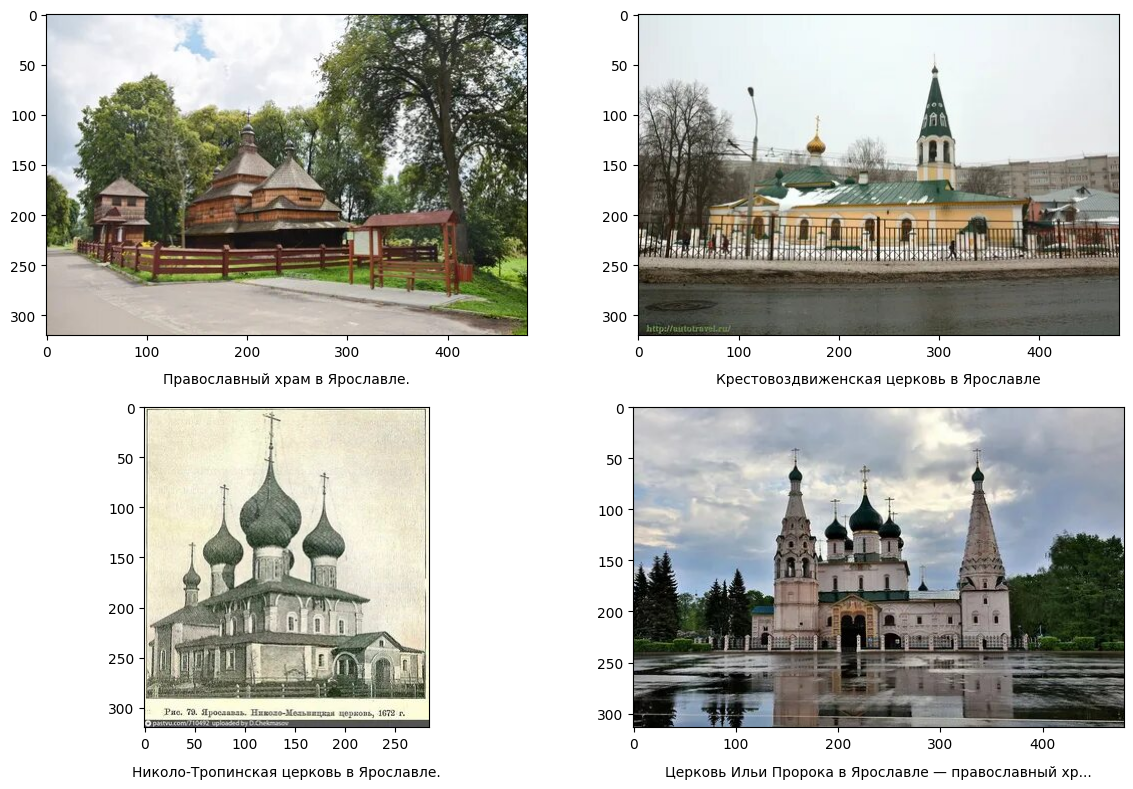

In [25]:
answer = RAG.get_answer('Церкви в Ярославле', display=True)

## **Поиск по изображениям**

В контексте упоминаются несколько мостов через реку Исеть в Екатеринбурге: Царский мост и Каменный мост. Также упоминается мост Волжские Ворота в Ярославле. Если вам нужна информация о конкретном мосте, уточните, пожалуйста.



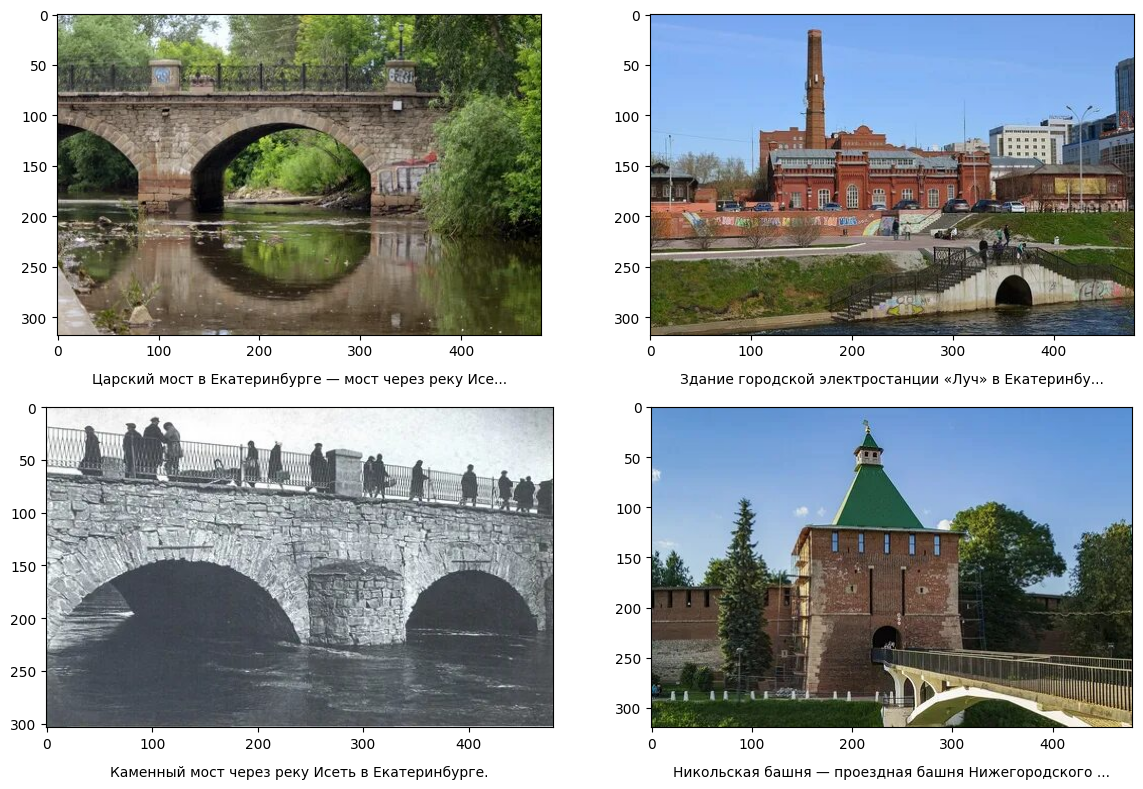

In [26]:
answer = RAG.get_answer('Мост через реку', display=True)


Для того, чтобы понять model as a judge подход из RAGAS, советуем посетить [этот кукбук](https://huggingface.co/learn/cookbook/en/rag_evaluation)

## **Метрика "Answer Semantic Similarity"**

In [28]:
result = answer_semantic_similarity(RAG, df_test)
print('МЕТРИКА "Answer Semantic Similarity"', result)

МЕТРИКА "Answer Semantic Similarity" 0.9086707520395039


# **Можно подводить итог**

## **Обработка данных**

Данные скудны, имеют множество дублей, пустые значения, в некоторых полях не пойми какой текст - может быть на испанском языке.

- данные почистили
- поля которые могут нам пригодиться для эмбединогов - конкатенировали
- сделали перевод с помощью Гугла googletrans==3.1.0a0 - теперь можно искать и по картинкам на русском языке
- тексты у нас короткие, разбивать на чанки - смысла нет

Визуализация длины основного комбинированного текста и текста описания картинок

## **Работа с выбросами**

Кластеризация с помощью векторов TF-IDF показала явные выбросы, особенно в кластере 7. Дальнейшее изучение выбросов показало, что это просто текст с описанием башен крепости, что тоже является допустимым в наших данных.

Таким образом мы неплохо почистили текст на предыдущих этапах. Данные выбросы - это просто немного другая тематика, но в рамках наших данных (башни крепости).

## **Выводы по визуализации векторов**

Очень хорошо разделились вектора по основному тексту (фиолетовый) и описанию для картинок (жёлтый).

В основном описании мы видим отдельное разделение по городам и в эмбеддингах описания картинок мы тоже видим отдельные группы.

## **Выбор модели**

При выборе модели исходил из ресурсов GPU, имеющихся в наличии.

Квантованые модели больших размеров работают лучше чем полноценные модели малых размеров.

**t-pro-it-1.0-q4_k_s/t-pro-it-1.0-q4_k_s.gguf** (2154 Гб занимал экземпляр класса на GPU)

Модель использовал для ответов RAG и для чистки датасета.

Модель T-pro справилась отлично, остальные модели, которые попробовал — по прежнему не слушалась инструкций. Выбор остановил на модели T-pro.

### **Поиск k-top=10 векторов**

Сработал очень хорошо, По запросу «Достопримечательности Ярославля» - все документы с упоминанием Ярославля. Так же протестировали работу модели по запросу, используя слова, отсутствующие в описании датасета, но есть похожая информация в описании картинок. Запрос был такой: «Крепость с башнями» - В k-top мы получили описание башен, крепостей, замков. Это очень хороший результат.

### **Работа реранкера**

Т.к. модель эмбеддера от BAAI показала показала очень хороший результат, то и в качестве реранкера было принято решение использовать реранкер этой же команды. Отдельно проверил работу реранкера — всё работает замечательно.

## **Получены хорошие метрики модели**
- Answer Relevancy: 0.7543
- Answer Semantic Similarity: 0.9084